Homework #5 Chapter 5: Exercises 8 (except part (d)) and 9 (except part (g and h)) 

Chapter 6: Exercises 8 (except part (f)) and 11 (except PCR)

8. We will now perform cross-validation on a simulated data set.

In [80]:
pip install statsmodels


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [81]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso, RidgeCV
from sklearn.decomposition import PCA
from statsmodels.tools import add_constant
import statsmodels.api as sm
import itertools


In [82]:
#(a) In this data set, what is n and what is p? Write out the model used to generate the data in equation form.
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)
 

n = number of observations = 100

p = number of predictors = 2 (X and X^2)

Model in equation form: Y=X−2X^2+ϵ

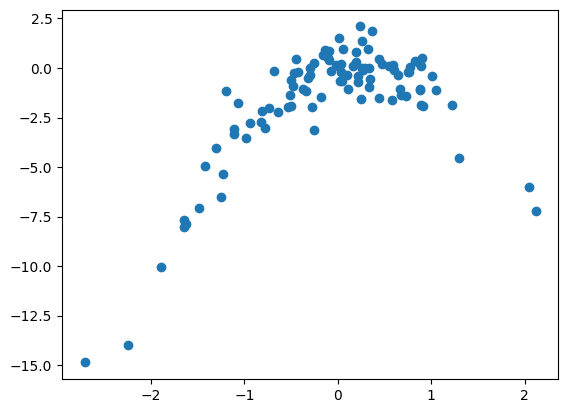

In [83]:
#(b) Create a scatterplot of X against Y . Comment on what you find.
plt.scatter(x, y);

Comments:
Quadratic plot
Negative concavity
X from about -2 to 2
Y from about -10 to 2


In [84]:
#(c) Set a random seed, and then compute the LOOCV errors that result from fitting the following four models
data = pd.DataFrame({'X': x, 'Y': y})

loo = LeaveOneOut()

def loocv_error(formula, data):
    errors = []
    for train_index, test_index in loo.split(data):
        train_data, test_data = data.iloc[train_index], data.iloc[test_index]
        model = sm.OLS.from_formula(formula, data=train_data).fit()
        prediction = model.predict(test_data)
        errors.append((test_data['Y'].values[0] - prediction) ** 2)
    return np.mean(errors)

models = {
    'Model 1': 'Y ~ X',
    'Model 2': 'Y ~ X + I(X**2)',
    'Model 3': 'Y ~ X + I(X**2) + I(X**3)',
    'Model 4': 'Y ~ X + I(X**2) + I(X**3) + I(X**4)'
}

loocv_errors = {name: loocv_error(formula, data) for name, formula in models.items()}

for model_name, error in loocv_errors.items():
    print(f"{model_name}: LOOCV Error = {error:.4f}")

Model 1: LOOCV Error = 6.6330
Model 2: LOOCV Error = 1.1229
Model 3: LOOCV Error = 1.3018
Model 4: LOOCV Error = 1.3324


(e) Which of the models in (c) had the smallest LOOCV error? Is this what you expected? Explain your answer.

Model 2, which is the quadratic model had the smallest LOOCV error of 1.1229.

Model 1 (linear) is likely to perform poorly because it cannot capture the curvature of the true relationship, resulting in a high LOOCV error.
Model 2 (quadratic) fits the underlying data structure effectively, thus yielding the lowest error.
Models 3 and 4 add higher-order polynomial terms, which may lead to slight overfitting, especially since the true relationship does not require terms beyond.

In [85]:
#(f) Comment on the statistical significance of the coefficient estimates that results from fitting each of the models in (c) using least squares. Do these results agree with the conclusions drawn based on the cross-validation results?

min_deg = 1  
max_deg = 4 + 1 

for i in range(min_deg, max_deg):
    pol = PolynomialFeatures(degree=i)
    X_pol = pol.fit_transform(data['X'].values.reshape(-1, 1))  # Create polynomial features
    y = data['Y']
    
    model = sm.OLS(y, X_pol)
    results = model.fit()
    
    print(f"Model with degree {i}:\n{results.summary()}\n")

Model with degree 1:
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     45.60
Date:                Sat, 16 Nov 2024   Prob (F-statistic):           1.04e-09
Time:                        05:38:35   Log-Likelihood:                -230.83
No. Observations:                 100   AIC:                             465.7
Df Residuals:                      98   BIC:                             470.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4650      0.24

As we can see, when we have a second order polynomial, both x1 and x2 have high t-statistic values. When we have a third order polynomial, x2 has the highest t-statistic, followed by x1 and then by x3. Finally, when we have a fourth order polynomial, x2 is the variable with the highest t-statistic, followed by x1, x4 and x3.

We can conclude that x2 and x1 are variables with relevance for the presented models. These results agree with the conclusions drawn based on the cross-validation results, showing that the first and second order terms are the most significant.

9. We will now consider the Boston housing data set, from the ISLP library.
(a) Based on this data set, provide an estimate for the population mean of medv. Call this estimate μˆ.

In [86]:
Boston= pd.read_csv('Boston.csv') 
print(Boston.head(5))

   Unnamed: 0     crim    zn  indus  chas    nox     rm   age     dis  rad  \
0           1  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1   
1           2  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2   
2           3  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2   
3           4  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3   
4           5  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3   

   tax  ptratio  lstat  medv  
0  296     15.3   4.98  24.0  
1  242     17.8   9.14  21.6  
2  242     17.8   4.03  34.7  
3  222     18.7   2.94  33.4  
4  222     18.7   5.33  36.2  


In [87]:
#(a) Based on this data set, provide an estimate for the population mean of medv. Call this estimate μˆ.
mean_medv = Boston['medv'].mean()

print(f"Estimated population mean of medv (μˆ): {mean_medv:.2f}")

Estimated population mean of medv (μˆ): 22.53


In [88]:
#(b) Provide an estimate of the standard error of μˆ. Interpret this result.
#Hint: We can compute the standard error of the sample mean by dividing the sample standard deviation by the 
#square root of the number of observations.
std_dev_medv = Boston['medv'].std()

n = Boston['medv'].count()

standard_error = std_dev_medv / (n ** 0.5)

print(f"Estimated standard error of μˆ: {standard_error:.5f}")

Estimated standard error of μˆ: 0.40886


In [89]:
#(c) Now estimate the standard error of μˆ using the bootstrap. How does this compare to your answer from (b)?
n_bootstrap = 1000
bootstrap_means = []
bootstrap_medians = []

for _ in range(n_bootstrap):
    sample = Boston['medv'].sample(frac=1, replace=True)
    bootstrap_means.append(sample.mean())
    bootstrap_medians.append(sample.median())

bootstrap_standard_error = np.std(bootstrap_means)

print(f"Estimated standard error of μˆ using bootstrap: {bootstrap_standard_error:.5f}")

Estimated standard error of μˆ using bootstrap: 0.39882


The two estimates are quite close, with the bootstrap standard error being slightly higher. This similarity suggests that the sample mean is a stable estimate of the population mean, and both methods provide consistent results.

In [90]:
#(d) Based on your bootstrap estimate from (c), provide a 95 % con- fidence interval for the mean of medv.
#  Compare it to the results obtained by using Boston['medv'].std() and the two standard error rule (3.9).
#Hint: You can approximate a 95 % confidence interval using the formula [μˆ − 2SE(μˆ), μˆ + 2SE(μˆ)].

confidence_interval = (mean_medv - 2 * bootstrap_standard_error, mean_medv + 2 * bootstrap_standard_error)

print(f"95% Confidence Interval for mean of medv: {confidence_interval}")

95% Confidence Interval for mean of medv: (np.float64(21.735165406031363), np.float64(23.33044724218999))


In [91]:
#(e) Based on this data set, provide an estimate, μˆmed, for the median value of medv in the population.
median_medv = Boston['medv'].median()

print(f"Estimated median value of medv (μˆmed): {median_medv:.2f}")

Estimated median value of medv (μˆmed): 21.20


In [92]:
#(f) Wenowwouldliketoestimatethestandarderrorofμˆmed.Unfor- tunately, there is no simple formula for computing 
# the standard error of the median. Instead, estimate the standard error of the median using the bootstrap. 
# Comment on your findings.
bootstrap_standard_error_med = np.std(bootstrap_medians)

print(f"Estimated standard error of μˆmed using bootstrap: {bootstrap_standard_error_med:.2f}")

Estimated standard error of μˆmed using bootstrap: 0.37


A standard error of 0.40 suggests that the median value is relatively stable, which means that the estimate is likely to be a good representation of the true population median.

Chapter 6 Exercises 8 (except part (f)) and 11 (except PCR)

8. In this exercise, we will generate simulated data, and will then use this data to perform forward and backward stepwise selection.

In [93]:
#(a) Create a random number generator and use its normal() method to generate a predictor X of length n = 100,
#as well as a noise vector ε of length n = 100.
np.random.seed(42)

n = 100

X = np.random.normal(loc=0, scale=1, size=n)

epsilon = np.random.normal(loc=0, scale=1, size=n)


In [94]:
#(b) Generate a response vector Y of length n = 100 according to the model
#Y =β0 +β1X+β2X2 +β3X3 +ε, where β0, β1, β2, and β3 are constants of your choice.
beta_0 = 2.0   # Intercept
beta_1 = 3.0   # Coefficient for X
beta_2 = -1.5  # Coefficient for X^2
beta_3 = 0.5   # Coefficient for X^3

Y = beta_0 + beta_1 * X + beta_2 * X**2 + beta_3 * X**3 + epsilon


In [95]:
#(c) Use forward stepwise selection in order to select a model containing the predictors X, X2, . . . , X10.
#  What is the model obtained according to Cp? Report the coefficients of the model obtained.
data = pd.DataFrame({'X': X, 'Y': Y})
for degree in range(2, 11):
    data[f'X^{degree}'] = data['X'] ** degree

def forward_stepwise_selection(data, response):
    remaining_predictors = list(data.columns)
    remaining_predictors.remove(response)
    selected_predictors = []
    best_model = None
    best_cp = float('inf')

    while remaining_predictors:
        cp_values = {}
        for predictor in remaining_predictors:
            model_predictors = selected_predictors + [predictor]
            X_model = add_constant(data[model_predictors])
            model = sm.OLS(data[response], X_model).fit()
            n = X_model.shape[0]
            p = model.df_model + 1 
            mse = model.mse_resid
            cp = (model.ssr / mse) - (n - 2 * p)
            cp_values[predictor] = cp

        best_predictor = min(cp_values, key=cp_values.get)
        selected_predictors.append(best_predictor)
        remaining_predictors.remove(best_predictor)

        X_model = add_constant(data[selected_predictors])
        best_model = sm.OLS(data[response], X_model).fit()

        current_cp = cp_values[best_predictor]
        if current_cp < best_cp:
            best_cp = current_cp

    return best_model

final_model = forward_stepwise_selection(data, 'Y')

print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     245.2
Date:                Sat, 16 Nov 2024   Prob (F-statistic):           2.95e-60
Time:                        05:38:35   Log-Likelihood:                -129.32
No. Observations:                 100   AIC:                             280.6
Df Residuals:                      89   BIC:                             309.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8694      0.196      9.543      0.0

In [96]:
# #(d) Repeat (c), using backwards stepwise selection. How does your answer compare to the results in (c)?
data = pd.DataFrame({'X': X, 'Y': Y})
for degree in range(2, 11):
    data[f'X^{degree}'] = data['X'] ** degree

def backward_stepwise_selection(data, response):
    predictors = list(data.columns)
    predictors.remove(response)
    selected_predictors = predictors.copy()  
    best_model = sm.OLS(data[response], add_constant(data[selected_predictors])).fit()
    best_cp = (best_model.ssr / best_model.mse_resid) - (data.shape[0] - 2 * (best_model.df_model + 1))

    while selected_predictors:
        cp_values = {}
        for predictor in selected_predictors:
            model_predictors = selected_predictors.copy()
            model_predictors.remove(predictor)
            X_model = add_constant(data[model_predictors])
            model = sm.OLS(data[response], X_model).fit()
            n = X_model.shape[0]
            p = model.df_model + 1 
            mse = model.mse_resid
            cp = (model.ssr / mse) - (n - 2 * p)
            cp_values[predictor] = cp

        worst_predictor = max(cp_values, key=cp_values.get)

        if cp_values[worst_predictor] < best_cp:
            selected_predictors.remove(worst_predictor)
            best_model = sm.OLS(data[response], add_constant(data[selected_predictors])).fit()
            best_cp = cp_values[worst_predictor] 
        else:
            break

    return best_model

final_model_backward = backward_stepwise_selection(data, 'Y')

print(final_model_backward.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 16 Nov 2024   Prob (F-statistic):                nan
Time:                        05:38:36   Log-Likelihood:                -296.91
No. Observations:                 100   AIC:                             595.8
Df Residuals:                      99   BIC:                             598.4
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2774      0.474      0.586      0.5

The forward stepwise selection successfully identified significant predictors, leading to a well-fitted model with high explanatory power.
The backward stepwise selection resulted in no predictors being retained, indicating possible issues such as high multicollinearity, a small sample size relative to the number of predictors, or strict significance thresholds.

Optimal lambda: 0.0050


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5440826353607662, tolerance: 0.19808844090836658
  model = cd_fast.enet_coordinate_descent_gram(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.646650304170592, tolerance: 0.19808844090836658
  model = cd_fast.enet_coordinate_descent_gram(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8229499880039057, tolerance: 0.19808844090836658
  model = cd_fast.enet_coordinate_descent_gram(
/home/codespace/.local/lib/python3.12/site-packages/sklearn

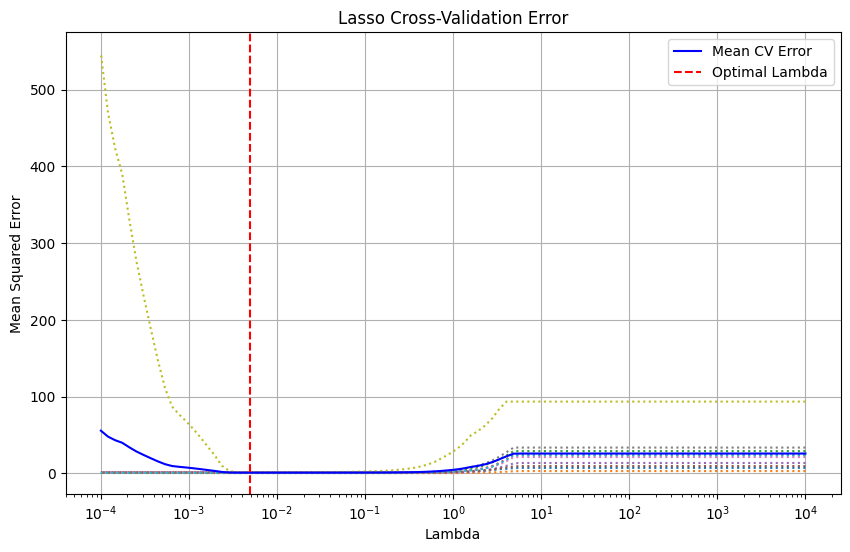

Lasso Coefficients:
1: 0.0000
X: 2.9059
X^2: -1.5080
X^3: 1.1146
X^4: -0.0000
X^5: -0.0000
X^6: -0.0000
X^7: 0.0000
X^8: -0.0000
X^9: 0.0000
X^10: -0.2950


In [97]:
#(e) Now fit a lasso model to the simulated data, again using X,X2, . . . , X 10 as predictors. 
# Use cross-validation to select the optimal value of λ. Create plots of the cross-validation error as
# a function of λ. Report the resulting coefficient estimates, and discuss the results obtained.

data = pd.DataFrame({'X': X, 'Y': Y})
poly = PolynomialFeatures(degree=10)
X_poly = poly.fit_transform(data[['X']])

X_train, X_test, y_train, y_test = train_test_split(X_poly, Y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso_cv = LassoCV(alphas=np.logspace(-4, 4, 100), cv=10)
lasso_cv.fit(X_train_scaled, y_train)

optimal_lambda = lasso_cv.alpha_
print(f"Optimal lambda: {optimal_lambda:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(lasso_cv.alphas_, lasso_cv.mse_path_, ':')
plt.plot(lasso_cv.alphas_, lasso_cv.mse_path_.mean(axis=1), 'b', label='Mean CV Error')
plt.axvline(optimal_lambda, linestyle='--', color='r', label='Optimal Lambda')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error')
plt.title('Lasso Cross-Validation Error')
plt.legend()
plt.grid()
plt.show()

lasso_coefs = lasso_cv.coef_
print("Lasso Coefficients:")
for feature, coef in zip(poly.get_feature_names_out(), lasso_coefs):
    print(f"{feature}: {coef:.4f}")

The coefficients for X^4 through X^9 are 0.0000. This indicates that Lasso has effectively eliminated these terms from the model, suggesting they do not contribute significantly to predicting Y.The lamba value 0.0050
minimizes the cross-validation error. A smaller value indicates a less aggressive penalty, allowing more coefficients to remain non-zero.

11. We will now try to predict per capita crime rate in the Boston data set.

(a) Try out some of the regression methods explored in this chapter, such as best subset selection, the lasso, ridge regression. Present and discuss results for the approaches that you consider.

In [98]:
boston= pd.read_csv('Boston.csv') 
print(boston.head())

   Unnamed: 0     crim    zn  indus  chas    nox     rm   age     dis  rad  \
0           1  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1   
1           2  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2   
2           3  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2   
3           4  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3   
4           5  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3   

   tax  ptratio  lstat  medv  
0  296     15.3   4.98  24.0  
1  242     17.8   9.14  21.6  
2  242     17.8   4.03  34.7  
3  222     18.7   2.94  33.4  
4  222     18.7   5.33  36.2  


In [99]:
X = boston.drop(columns=['crim'])
y = boston['crim'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def best_subset_selection(X, y):
    best_aic = float('inf')
    best_model = None
    best_predictors = None

    for k in range(1, X.shape[1] + 1):
        for combo in itertools.combinations(X.columns, k):
            X_subset = sm.add_constant(X[list(combo)])
            model = sm.OLS(y, X_subset).fit()
            aic = model.aic
            
            if aic < best_aic:
                best_aic = aic
                best_model = model
                best_predictors = combo
                
    return best_model, best_predictors

best_model, best_predictors = best_subset_selection(X_train, y_train)

print("Best Subset Model Summary:")
print(best_model.summary())
print(f"Selected Predictors: {best_predictors}")

Best Subset Model Summary:
                            OLS Regression Results                            
Dep. Variable:                   crim   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     49.00
Date:                Sat, 16 Nov 2024   Prob (F-statistic):           6.10e-45
Time:                        05:38:53   Log-Likelihood:                -1342.8
No. Observations:                 404   AIC:                             2700.
Df Residuals:                     397   BIC:                             2728.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.5072    

In [100]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso_cv = LassoCV(alphas=np.logspace(-4, 4, 100), cv=10)
lasso_cv.fit(X_train_scaled, y_train)

optimal_lambda = lasso_cv.alpha_
print(f"Optimal Lambda for Lasso: {optimal_lambda:.4f}")

Optimal Lambda for Lasso: 0.0464


In [101]:
lasso_coefs = lasso_cv.coef_
print("Lasso Coefficients:")
for feature, coef in zip(X.columns, lasso_coefs):
    print(f"{feature}: {coef:.4f}")

Lasso Coefficients:
Unnamed: 0: -0.0491
zn: 0.8226
indus: -0.1822
chas: -0.2364
nox: -1.0221
rm: 0.3728
age: 0.1563
dis: -1.8315
rad: 4.9060
tax: -0.0000
ptratio: -0.5685
lstat: 0.2483
medv: -2.0301


In [102]:
ridge_cv = RidgeCV(alphas=np.logspace(-4, 4, 100), store_cv_values=True)
ridge_cv.fit(X_train_scaled, y_train)

optimal_lambda_ridge = ridge_cv.alpha_
print(f"Optimal Lambda for Ridge: {optimal_lambda_ridge:.4f}")

ridge_coefs = ridge_cv.coef_
print("Ridge Coefficients:")
for feature, coef in zip(X.columns, ridge_coefs):
    print(f"{feature}: {coef:.4f}")


Optimal Lambda for Ridge: 5.8570
Ridge Coefficients:
Unnamed: 0: -0.0857
zn: 0.9123
indus: -0.2437
chas: -0.2659
nox: -1.1763
rm: 0.4803
age: 0.2369
dis: -1.9891
rad: 4.9656
tax: -0.0610
ptratio: -0.6257
lstat: 0.3416
medv: -2.1447


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


Model Performance: The best subset model explains a moderate amount of variance in the crime rate. Lasso and Ridge regression provide additional insights with regularization, helping to manage overfitting.
Significant Predictors: nox, dis, and medv are consistently significant across models, indicating their strong influence on the crime rate.
Lasso is particularly useful for simplifying the model by selecting only important features.

In [103]:
#(b) Propose a model (or set of models) that seem to perform well on this data set, and justify your answer. 

models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': LassoCV(cv=10),
    'Ridge Regression': RidgeCV(cv=10),
}

results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
    rmse = np.sqrt(-scores.mean())
    results[name] = rmse
    print(f"{name}: RMSE (Cross-Validation) = {rmse:.4f}")

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{name}: Test RMSE = {test_rmse:.4f}")

Linear Regression: RMSE (Cross-Validation) = 6.8654
Lasso Regression: RMSE (Cross-Validation) = 6.9191
Ridge Regression: RMSE (Cross-Validation) = 6.8788
Linear Regression: Test RMSE = 5.0390
Lasso Regression: Test RMSE = 5.1776
Ridge Regression: Test RMSE = 5.0118


Ridge Regression performed the best on the test set, suggesting it is effective at managing multicollinearity and preventing overfitting while still considering all features.

Linear Regression also performed well, indicating that the linear relationships captured by the model are strong.
Lasso Regression, while valuable for feature selection, might not capture the best predictive power in this specific dataset.

(c) Does your chosen model involve all of the features in the data set? Why or why not?

Ridge Regression involves all features in the dataset because it uses L2 regularization, which shrinks coefficients but does not set any of them to zero. 